In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

## 0. Install and Import modules
Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [1]:
import os
import sys
import torch
import subprocess
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [167]:
# %matplotlib inline
# %matplotlib notebook
import os
import sys
import time
import json
import glob
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython import display
from tqdm.notebook import tqdm

# Data structures and functions for rendering
from pytorch3d.structures import Volumes
from pytorch3d.transforms import so3_exp_map
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    NDCMultinomialRaysampler,
    MonteCarloRaysampler,
    EmissionAbsorptionRaymarcher,
    ImplicitRenderer,
    RayBundle,
    ray_bundle_to_ray_points,
)

# obtain the utilized device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    print(
        'Please note that NeRF is a resource-demanding method.'
        + ' Running this notebook on CPU will be extremely slow.'
        + ' We recommend running the example on a GPU'
        + ' with at least 10 GB of memory.'
    )
    device = torch.device("cpu")

In [168]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [169]:
path = '/content/drive/MyDrive/nerf/nerf'

In [170]:

contents = os.listdir(path)
print(contents)

['omg_a_lot_had_been.py', '3DPastry001_HQ-1K-JPG.zip', '3DApple001_HQ-1K-JPG 1.zip', 'checkpoint_epoch_19900.pth', 'final_model (1).pth', '3DPastry001_LQ-1K-JPG_AmbientOcclusion.jpg', '3DPastry001_LQ-1K-JPG.usdc', '3DPastry001_LQ-1K-JPG_NormalGL.jpg', 'generate_cow_renders.py', 'plot_image_grid.py', '__pycache__', 'nerf', 'pastry_new', 'output']


In [171]:
import os

# Define the specific path you want to check
path_to_check = '/content/drive/MyDrive/nerf/nerf'  # Change this to your specific folder

# Check if the path exists and list its contents
if os.path.exists(path_to_check):
    print(f"The path '{path_to_check}' exists.")
    contents = os.listdir(path_to_check)
    print("Contents of the directory:")
    for item in contents:
        print(item)
else:
    print(f"The path '{path_to_check}' does not exist.")


The path '/content/drive/MyDrive/nerf/nerf' exists.
Contents of the directory:
omg_a_lot_had_been.py
3DPastry001_HQ-1K-JPG.zip
3DApple001_HQ-1K-JPG 1.zip
checkpoint_epoch_19900.pth
final_model (1).pth
3DPastry001_LQ-1K-JPG_AmbientOcclusion.jpg
3DPastry001_LQ-1K-JPG.usdc
3DPastry001_LQ-1K-JPG_NormalGL.jpg
generate_cow_renders.py
plot_image_grid.py
__pycache__
nerf
pastry_new
output


In [172]:
import os

# Confirm the directory contents
print("Files in '/content/drive/MyDrive/nerf/nerf':", os.listdir('/content/drive/MyDrive/nerf/nerf'))




Files in '/content/drive/MyDrive/nerf/nerf': ['omg_a_lot_had_been.py', '3DPastry001_HQ-1K-JPG.zip', '3DApple001_HQ-1K-JPG 1.zip', 'checkpoint_epoch_19900.pth', 'final_model (1).pth', '3DPastry001_LQ-1K-JPG_AmbientOcclusion.jpg', '3DPastry001_LQ-1K-JPG.usdc', '3DPastry001_LQ-1K-JPG_NormalGL.jpg', 'generate_cow_renders.py', 'plot_image_grid.py', '__pycache__', 'nerf', 'pastry_new', 'output']


In [173]:
import sys
sys.path.append('/content/drive/MyDrive/nerf/nerf')
# Verify if the path is added correctly
print(sys.path)


['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/drive/MyDrive/nerf/nerf', '/content/drive/MyDrive/nerf/nerf', '/tmp/tmpar3p5q7e', '/content/drive/MyDrive/nerf/nerf']


In [174]:
import importlib
import sys
import os

# Add the directory containing plot_image_grid to the system path
# Assuming plot_image_grid.py is in '/content/drive/MyDrive/3d_data'
sys.path.append('/content/drive/MyDrive/nerf/nerf')

# Verify if the path is added correctly
print(sys.path)

# List files in the directory to check for plot_image_grid.py
print("Files in '/content/drive/MyDrive/nerf/nerf':", os.listdir('/content/drive/MyDrive/nerf/nerf'))

# Attempt to import the module
try:
    import plot_image_grid
    print("Successfully imported 'plot_image_grid'")
    importlib.reload(plot_image_grid)
except ModuleNotFoundError:
    print("Error: Module 'plot_image_grid' not found. Please ensure:")
    print("1. The module file (plot_image_grid.py) is present in '/content/drive/MyDrive/nerf/nerf'.")
    print("2. The file name and module name are spelled correctly.")
    print("3. If it's a custom module, it has the necessary 'import' statements for any dependencies.")

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/drive/MyDrive/nerf/nerf', '/content/drive/MyDrive/nerf/nerf', '/tmp/tmpar3p5q7e', '/content/drive/MyDrive/nerf/nerf', '/content/drive/MyDrive/nerf/nerf']
Files in '/content/drive/MyDrive/nerf/nerf': ['omg_a_lot_had_been.py', '3DPastry001_HQ-1K-JPG.zip', '3DApple001_HQ-1K-JPG 1.zip', 'checkpoint_epoch_19900.pth', 'final_model (1).pth', '3DPastry001_LQ-1K-JPG_AmbientOcclusion.jpg', '3DPastry001_LQ-1K-JPG.usdc', '3DPastry001_LQ-1K-JPG_NormalGL.jpg', 'generate_cow_renders.py', 'plot_image_grid.py', '__pycache__', 'nerf', 'pastry_new', 'output']
Successfully imported 'plot_image_grid'


In [175]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.
#
# This source code is licensed under the BSD-style license found in the
# LICENSE file in the root directory of this source tree.

import matplotlib.pyplot as plt


def image_grid(
    images,
    rows=None,
    cols=None,
    fill: bool = True,
    show_axes: bool = False,
    rgb: bool = True,
):
    """
    A util function for plotting a grid of images.

    Args:
        images: (N, H, W, 4) array of RGBA images
        rows: number of rows in the grid
        cols: number of columns in the grid
        fill: boolean indicating if the space between images should be filled
        show_axes: boolean indicating if the axes of the plots should be visible
        rgb: boolean, If True, only RGB channels are plotted.
            If False, only the alpha channel is plotted.

    Returns:
        None
    """
    if (rows is None) != (cols is None):
        raise ValueError("Specify either both rows and cols or neither.")

    if rows is None:
        rows = len(images)
        cols = 1

    gridspec_kw = {"wspace": 0.0, "hspace": 0.0} if fill else {}
    fig, axarr = plt.subplots(rows, cols, gridspec_kw=gridspec_kw, figsize=(15, 9))
    bleed = 0
    fig.subplots_adjust(left=bleed, bottom=bleed, right=(1 - bleed), top=(1 - bleed))

    for ax, im in zip(axarr.ravel(), images):
        if rgb:
            # only render RGB channels
            ax.imshow(im[..., :3])
        else:
            # only render Alpha channel
            ax.imshow(im[..., 3])
        if not show_axes:
            ax.set_axis_off()

In [176]:
import importlib
#import plot_image_grid
#importlib.reload(plot_image_grid)


In [177]:
# Try to import the files
try:
    from plot_image_grid import image_grid
    from generate_cow_renders import generate_cow_renders
    print("Modules imported successfully.")
except ImportError as e:
    print(f"Error importing modules: {e}")

# Check if functions are accessible
print("Available functions:")
print(dir())  # This will list all the names in the current scope

# Optionally, try calling a function if you know it exists
try:
    # Replace 'some_function' with an actual function name from your module
    # Example: image_grid(some_arguments)
    print("Calling image_grid function:")
    # image_grid(...)  # Uncomment this line to call the function if you have arguments
except Exception as e:
    print(f"Error calling function: {e}")



Modules imported successfully.
Available functions:
['BlendParams', 'Compose', 'DATA_DIR', 'EmissionAbsorptionRaymarcher', 'F', 'FoVPerspectiveCameras', 'HTML', 'HarmonicEmbedding', 'Image', 'ImplicitRenderer', 'In', 'MeshRasterizer', 'MeshRenderer', 'Meshes', 'MonteCarloRaysampler', 'NDCMultinomialRaysampler', 'NeuralRadianceField', 'Normalize', 'Out', 'PerspectiveCameras', 'PointLights', 'RasterizationSettings', 'RayBundle', 'Resize', 'Rotate', 'SUBFOLDER_PATH', 'SoftPhongShader', 'SoftSilhouetteShader', 'TexturesVertex', 'ToTensor', 'Volumes', '_', '_31', '_45', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_exit_code', '_i', '_i1', '_i10', '_i100', '_i101', '_i102', '_i103', '_i104', '_i105', '_i106', '_i107', '_i108', '_i109', '_i11', '_i110', '_i111', '_i112', '_i113', '_i114', '_i115', '_i116', '_i117', '_i118', '_i119', '_i12', '_i120', '_i121', '_i122', '_i123', '_i124', '_i125', '_i126', '_i127', '_i128', '

OBJ file path: /content/drive/MyDrive/nerf/nerf/pastry_new/3DMelon001_LQ-2K-JPG.obj
MTL file path: /content/drive/MyDrive/nerf/nerf/pastry_new/3DMelon001_LQ-2K-JPG.mtl
Texture file path: /content/drive/MyDrive/nerf/nerf/pastry_new/3DMelon001_LQ-2K-JPG_Color.jpg


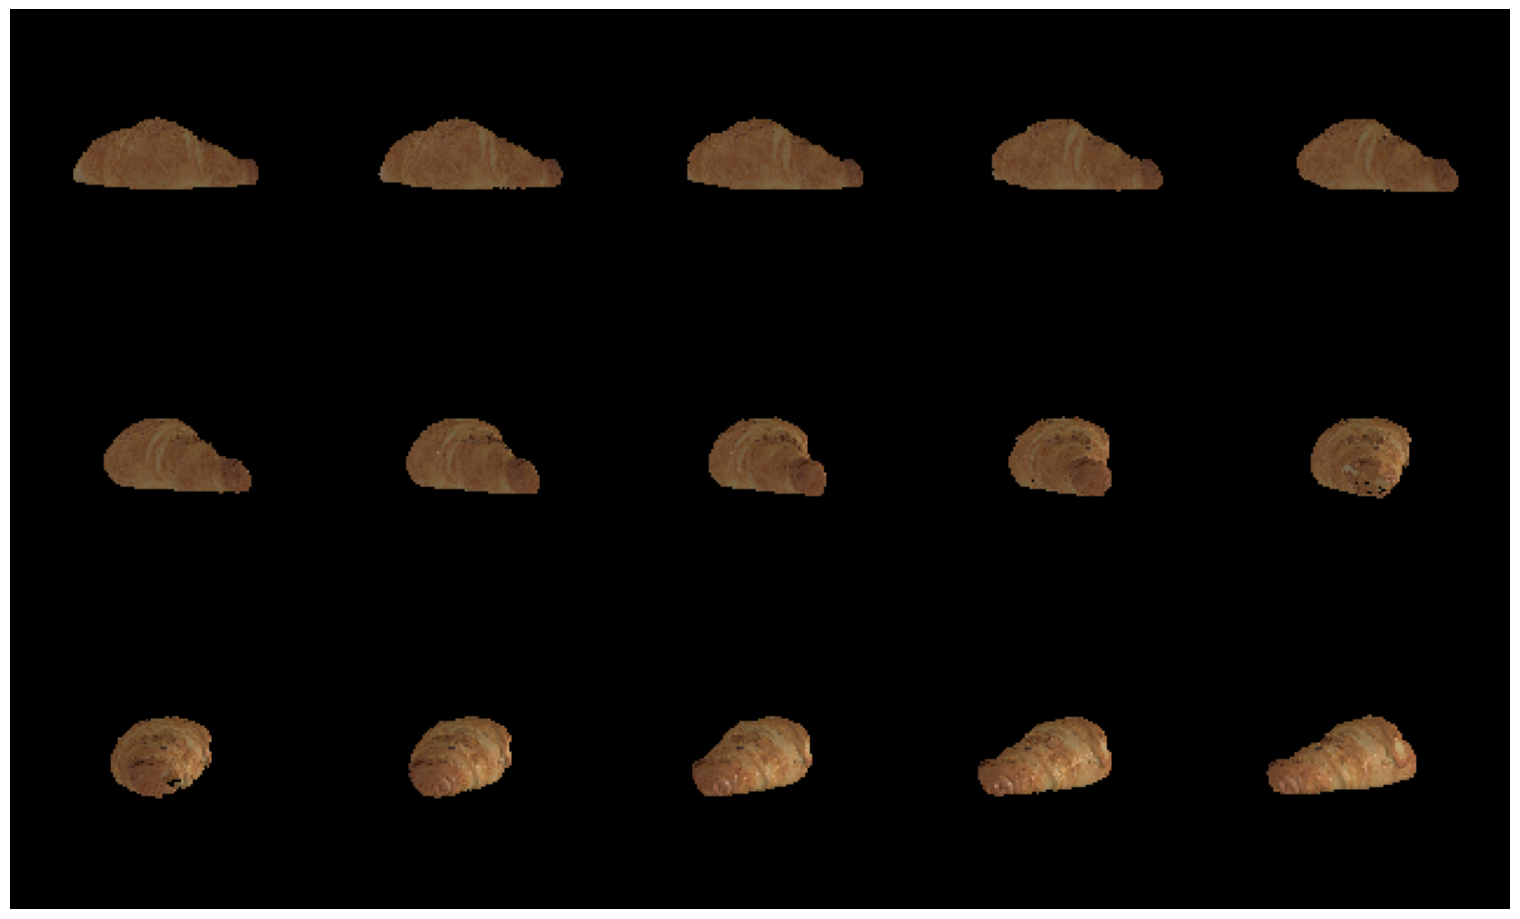

In [178]:
#import os

import numpy as np
import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    BlendParams,
    FoVPerspectiveCameras,
    look_at_view_transform,
    MeshRasterizer,
    MeshRenderer,
    PointLights,
    RasterizationSettings,
    SoftPhongShader,
    SoftSilhouetteShader,
)
import imageio
import matplotlib.pyplot as plt

# create the default data directory
#current_dir = os.path.dirname(os.path.realpath(__file__))
#DATA_DIR = os.path.join(current_dir, "..", "data", "cow_mesh")

# Set the data directory to the current directory
#DATA_DIR = os.path.dirname(os.path.realpath('/content/drive/MyDrive/nerf/'))
DATA_DIR = '/content/drive/MyDrive/nerf/nerf' # Changed to your intended path

# Define the path to the subfolder where your files are stored
SUBFOLDER_PATH = os.path.join(DATA_DIR, 'pastry_new')

# Define the names of your custom files
custom_obj_file = os.path.join(SUBFOLDER_PATH, "3DMelon001_LQ-2K-JPG.obj")       # Path to the .obj file
custom_mtl_file = os.path.join(SUBFOLDER_PATH, "3DMelon001_LQ-2K-JPG.mtl")     # Path to the .mtl file
custom_texture_file = os.path.join(SUBFOLDER_PATH, "3DMelon001_LQ-2K-JPG_Color.jpg")  # Path to the texture file

# You can now use these paths in your code
print("OBJ file path:", custom_obj_file)
print("MTL file path:", custom_mtl_file)
print("Texture file path:", custom_texture_file)


def generate_cow_renders(
    num_views: int = 40, data_dir: str = SUBFOLDER_PATH, azimuth_range: float = 180
):
    """
    This function generates `num_views` renders of a mesh.
    The renders are generated from viewpoints sampled at uniformly distributed
    azimuth intervals. The elevation is kept constant so that the camera's
    vertical position coincides with the equator.

    Args:
        num_views: The number of generated renders.
        data_dir: The folder that contains the mesh files. It expects an
            obj file, mtl file, and texture file in this directory.
        azimuth_range: number of degrees on each side of the start position to
            take samples.

    Returns:
        cameras: A batch of `num_views` `FoVPerspectiveCameras` from which the
            images are rendered.
        images: A tensor of shape `(num_views, height, width, 3)` containing
            the rendered images.
        silhouettes: A tensor of shape `(num_views, height, width)` containing
            the rendered silhouettes.
    """

    # Define the paths to the mesh files
    custom_obj_path = os.path.join(data_dir, "3DPastry001_HQ-1K-JPG.obj")
    custom_mtl_path = os.path.join(data_dir, "3DPastry001_HQ-1K-JPG.mtl")
    custom_texture_path = os.path.join(data_dir, "3DPastry001_HQ-1K-JPG_Color.jpg")

    # Check if the mesh files exist
    if not os.path.isfile(custom_obj_path) or not os.path.isfile(custom_mtl_path):
        raise FileNotFoundError("One or more mesh files do not exist in the specified directory.")

    # Setup device for rendering
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")

    # Load the OBJ file and associated material
    mesh = load_objs_as_meshes([custom_obj_path], device=device)

    # Normalize and center the target mesh
    verts = mesh.verts_packed()
    N = verts.shape[0]
    center = verts.mean(0)
    scale = max((verts - center).abs().max(0)[0])
    mesh.offset_verts_(-(center.expand(N, 3)))
    mesh.scale_verts_((1.0 / float(scale)))

    # Create a batch of viewing angles
    elev = torch.linspace(0, 0, num_views)  # Keep elevation constant
    azim = torch.linspace(-azimuth_range, azimuth_range, num_views) + 180.0

    # Setup lighting
    lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

    # Initialize the camera
    R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

    # Set up rasterization settings
    raster_settings = RasterizationSettings(image_size=128, blur_radius=0.0, faces_per_pixel=1)
    blend_params = BlendParams(sigma=1e-4, gamma=1e-4, background_color=(0.0, 0.0, 0.0))

    # Create the renderer
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
        shader=SoftPhongShader(device=device, cameras=cameras, lights=lights, blend_params=blend_params),
    )

    # Create a batch of meshes by repeating the original mesh
    meshes = mesh.extend(num_views)

    # Render the mesh from each viewing angle
    target_images = renderer(meshes, cameras=cameras, lights=lights)

    # Silhouette rendering setup
    raster_settings_silhouette = RasterizationSettings(
        image_size=128, blur_radius=np.log(1.0 / 1e-4 - 1.0) * 1e-4, faces_per_pixel=50
    )
    renderer_silhouette = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings_silhouette),
        shader=SoftSilhouetteShader(),
    )

    # Render silhouettes
    silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
    silhouette_binary = (silhouette_images[..., 3] > 1e-4).float()

    return cameras, target_images[..., :3], silhouette_binary

target_cameras, target_images, target_silhouettes = generate_cow_renders(num_views=40, azimuth_range=180)
image_grid(target_images.clamp(0., 1.).cpu().numpy(), rows=3, cols=5, rgb=True, fill=True)
plt.show()

In [179]:
# render_size describes the size of both sides of the
# rendered images in pixels. Since an advantage of
# Neural Radiance Fields are high quality renders
# with a significant amount of details, we render
# the implicit function at double the size of
# target images.
render_size = target_images.shape[1] * 2

# Our rendered scene is centered around (0,0,0)
# and is enclosed inside a bounding box
# whose side is roughly equal to 3.0 (world units).
volume_extent_world = 3.0

# 1) Instantiate the raysamplers.

# Here, NDCMultinomialRaysampler generates a rectangular image
# grid of rays whose coordinates follow the PyTorch3D
# coordinate conventions.
raysampler_grid = NDCMultinomialRaysampler(
    image_height=render_size,
    image_width=render_size,
    n_pts_per_ray=128,
    min_depth=0.1,
    max_depth=volume_extent_world,
)

# MonteCarloRaysampler generates a random subset
# of `n_rays_per_image` rays emitted from the image plane.
raysampler_mc = MonteCarloRaysampler(
    min_x = -1.0,
    max_x = 1.0,
    min_y = -1.0,
    max_y = 1.0,
    n_rays_per_image=750,
    n_pts_per_ray=128,
    min_depth=0.1,
    max_depth=volume_extent_world,
)

# 2) Instantiate the raymarcher.
# Here, we use the standard EmissionAbsorptionRaymarcher
# which marches along each ray in order to render
# the ray into a single 3D color vector
# and an opacity scalar.
raymarcher = EmissionAbsorptionRaymarcher()

# Finally, instantiate the implicit renders
# for both raysamplers.
renderer_grid = ImplicitRenderer(
    raysampler=raysampler_grid, raymarcher=raymarcher,
)
renderer_mc = ImplicitRenderer(
    raysampler=raysampler_mc, raymarcher=raymarcher,
)

In [180]:
class HarmonicEmbedding(torch.nn.Module):
    def __init__(self, n_harmonic_functions=60, omega0=0.1):
        """
        Given an input tensor `x` of shape [minibatch, ... , dim],
        the harmonic embedding layer converts each feature
        in `x` into a series of harmonic features `embedding`
        as follows:
            embedding[..., i*dim:(i+1)*dim] = [
                sin(x[..., i]),
                sin(2*x[..., i]),
                sin(4*x[..., i]),
                ...
                sin(2**(self.n_harmonic_functions-1) * x[..., i]),
                cos(x[..., i]),
                cos(2*x[..., i]),
                cos(4*x[..., i]),
                ...
                cos(2**(self.n_harmonic_functions-1) * x[..., i])
            ]

        Note that `x` is also premultiplied by `omega0` before
        evaluating the harmonic functions.
        """
        super().__init__()
        self.register_buffer(
            'frequencies',
            omega0 * (2.0 ** torch.arange(n_harmonic_functions)),
        )
    def forward(self, x):
        """
        Args:
            x: tensor of shape [..., dim]
        Returns:
            embedding: a harmonic embedding of `x`
                of shape [..., n_harmonic_functions * dim * 2]
        """
        frequencies = self.frequencies.to(x.device)
        x = x.to(self.frequencies.device)
        embed = (x[..., None] * self.frequencies).view(*x.shape[:-1], -1)
        return torch.cat((embed.sin(), embed.cos()), dim=-1)


class NeuralRadianceField(torch.nn.Module):
    def __init__(self, n_harmonic_functions=60, n_hidden_neurons=256):
        super().__init__()
        """
        Args:
            n_harmonic_functions: The number of harmonic functions
                used to form the harmonic embedding of each point.
            n_hidden_neurons: The number of hidden units in the
                fully connected layers of the MLPs of the model.
        """

        # The harmonic embedding layer converts input 3D coordinates
        # to a representation that is more suitable for
        # processing with a deep neural network.
        self.harmonic_embedding = HarmonicEmbedding(n_harmonic_functions)

        # The dimension of the harmonic embedding.
        embedding_dim = n_harmonic_functions * 2 * 3

        # self.mlp is a simple 2-layer multi-layer perceptron
        # which converts the input per-point harmonic embeddings
        # to a latent representation.
        # Not that we use Softplus activations instead of ReLU.
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(embedding_dim, n_hidden_neurons),
            torch.nn.Softplus(beta=10.0),
            torch.nn.Linear(n_hidden_neurons, n_hidden_neurons),
            torch.nn.Softplus(beta=10.0),
        )

        # Given features predicted by self.mlp, self.color_layer
        # is responsible for predicting a 3-D per-point vector
        # that represents the RGB color of the point.
        self.color_layer = torch.nn.Sequential(
            torch.nn.Linear(n_hidden_neurons + embedding_dim, n_hidden_neurons),
            torch.nn.Softplus(beta=10.0),
            torch.nn.Linear(n_hidden_neurons, 3),
            torch.nn.Sigmoid(),
            # To ensure that the colors correctly range between [0-1],
            # the layer is terminated with a sigmoid layer.
        )

        # The density layer converts the features of self.mlp
        # to a 1D density value representing the raw opacity
        # of each point.
        self.density_layer = torch.nn.Sequential(
            torch.nn.Linear(n_hidden_neurons, 1),
            torch.nn.Softplus(beta=10.0),
            # Sofplus activation ensures that the raw opacity
            # is a non-negative number.
        )

        # We set the bias of the density layer to -1.5
        # in order to initialize the opacities of the
        # ray points to values close to 0.
        # This is a crucial detail for ensuring convergence
        # of the model.
        self.density_layer[0].bias.data[0] = -1.5

        # Initialize attributes to store ray data
        self.lengths = None
        self.xys = None
        self.directions = None

    def _get_densities(self, features):
        """
        This function takes `features` predicted by `self.mlp`
        and converts them to `raw_densities` with `self.density_layer`.
        `raw_densities` are later mapped to [0-1] range with
        1 - inverse exponential of `raw_densities`.
        """
        raw_densities = self.density_layer(features)
        return 1 - (-raw_densities).exp()

    def _get_colors(self, features, rays_directions):
        """
        This function takes per-point `features` predicted by `self.mlp`
        and evaluates the color model in order to attach to each
        point a 3D vector of its RGB color.

        In order to represent viewpoint dependent effects,
        before evaluating `self.color_layer`, `NeuralRadianceField`
        concatenates to the `features` a harmonic embedding
        of `ray_directions`, which are per-point directions
        of point rays expressed as 3D l2-normalized vectors
        in world coordinates.
        """
        spatial_size = features.shape[:-1]

        # Normalize the ray_directions to unit l2 norm.
        rays_directions_normed = torch.nn.functional.normalize(
            rays_directions, dim=-1
        )

        # Obtain the harmonic embedding of the normalized ray directions.
        rays_embedding = self.harmonic_embedding(
            rays_directions_normed
        )

        # Expand the ray directions tensor so that its spatial size
        # is equal to the size of features.
        rays_embedding_expand = rays_embedding[..., None, :].expand(
            *spatial_size, rays_embedding.shape[-1]
        )

        # Concatenate ray direction embeddings with
        # features and evaluate the color model.
        color_layer_input = torch.cat(
            (features, rays_embedding_expand),
            dim=-1
        )
        return self.color_layer(color_layer_input)


    def forward(
        self,
        ray_bundle: RayBundle,
        **kwargs,
    ):
        """
        The forward function accepts the parametrizations of
        3D points sampled along projection rays. The forward
        pass is responsible for attaching a 3D vector
        and a 1D scalar representing the point's
        RGB color and opacity respectively.

        Args:
            ray_bundle: A RayBundle object containing the following variables:
                origins: A tensor of shape `(minibatch, ..., 3)` denoting the
                    origins of the sampling rays in world coords.
                directions: A tensor of shape `(minibatch, ..., 3)`
                    containing the direction vectors of sampling rays in world coords.
                lengths: A tensor of shape `(minibatch, ..., num_points_per_ray)`
                    containing the lengths at which the rays are sampled.

        Returns:
            rays_densities: A tensor of shape `(minibatch, ..., num_points_per_ray, 1)`
                denoting the opacity of each ray point.
            rays_colors: A tensor of shape `(minibatch, ..., num_points_per_ray, 3)`
                denoting the color of each ray point.
        """
        # Store ray data for future use
        self.lengths = ray_bundle.lengths
        self.xys = ray_bundle.xys
        self.directions = ray_bundle.directions


        # We first convert the ray parametrizations to world
        # coordinates with `ray_bundle_to_ray_points`.
        rays_points_world = ray_bundle_to_ray_points(ray_bundle)
        # rays_points_world.shape = [minibatch x ... x 3]

        # For each 3D world coordinate, we obtain its harmonic embedding.
        embeds = self.harmonic_embedding(
            rays_points_world
        )
        # embeds.shape = [minibatch x ... x self.n_harmonic_functions*6]

        # self.mlp maps each harmonic embedding to a latent feature space.
        features = self.mlp(embeds)
        # features.shape = [minibatch x ... x n_hidden_neurons]

        # Finally, given the per-point features,
        # execute the density and color branches.

        rays_densities = self._get_densities(features)
        # rays_densities.shape = [minibatch x ... x 1]

        rays_colors = self._get_colors(features, ray_bundle.directions)
        # rays_colors.shape = [minibatch x ... x 3]

        return rays_densities, rays_colors

    def batched_forward(
        self,
        ray_bundle: RayBundle,
        n_batches: int = 16,
        **kwargs,
    ):
        """
        This function is used to allow for memory efficient processing
        of input rays. The input rays are first split to `n_batches`
        chunks and passed through the `self.forward` function one at a time
        in a for loop. Combined with disabling PyTorch gradient caching
        (`torch.no_grad()`), this allows for rendering large batches
        of rays that do not all fit into GPU memory in a single forward pass.
        In our case, batched_forward is used to export a fully-sized render
        of the radiance field for visualization purposes.

        Args:
            ray_bundle: A RayBundle object containing the following variables:
                origins: A tensor of shape `(minibatch, ..., 3)` denoting the
                    origins of the sampling rays in world coords.
                directions: A tensor of shape `(minibatch, ..., 3)`
                    containing the direction vectors of sampling rays in world coords.
                lengths: A tensor of shape `(minibatch, ..., num_points_per_ray)`
                    containing the lengths at which the rays are sampled.
            n_batches: Specifies the number of batches the input rays are split into.
                The larger the number of batches, the smaller the memory footprint
                and the lower the processing speed.

        Returns:
            rays_densities: A tensor of shape `(minibatch, ..., num_points_per_ray, 1)`
                denoting the opacity of each ray point.
            rays_colors: A tensor of shape `(minibatch, ..., num_points_per_ray, 3)`
                denoting the color of each ray point.

        """

        # Parse out shapes needed for tensor reshaping in this function.
        n_pts_per_ray = ray_bundle.lengths.shape[-1]
        spatial_size = [*ray_bundle.origins.shape[:-1], n_pts_per_ray]

        # Split the rays to `n_batches` batches.
        tot_samples = ray_bundle.origins.shape[:-1].numel()
        batches = torch.chunk(torch.arange(tot_samples), n_batches)

        # For each batch, execute the standard forward pass.
        batch_outputs = [
            self.forward(
                RayBundle(
                    origins=ray_bundle.origins.view(-1, 3)[batch_idx],
                    directions=ray_bundle.directions.view(-1, 3)[batch_idx],
                    lengths=ray_bundle.lengths.view(-1, n_pts_per_ray)[batch_idx],
                    xys=None,
                )
            ) for batch_idx in batches
        ]

        # Concatenate the per-batch rays_densities and rays_colors
        # and reshape according to the sizes of the inputs.
        rays_densities, rays_colors = [
            torch.cat(
                [batch_output[output_i] for batch_output in batch_outputs], dim=0
            ).view(*spatial_size, -1) for output_i in (0, 1)
        ]
        return rays_densities, rays_colors

## 4. Helper functions

In this function we define functions that help with the Neural Radiance Field optimization.

In [181]:
def huber(x, y, scaling=0.1):
    """
    A helper function for evaluating the smooth L1 (huber) loss
    between the rendered silhouettes and colors.
    """
    diff_sq = (x - y) ** 2
    loss = ((1 + diff_sq / (scaling**2)).clamp(1e-4).sqrt() - 1) * float(scaling)
    return loss

def sample_images_at_mc_locs(target_images, sampled_rays_xy):
    """
    Given a set of Monte Carlo pixel locations `sampled_rays_xy`,
    this method samples the tensor `target_images` at the
    respective 2D locations.

    This function is used in order to extract the colors from
    ground truth images that correspond to the colors
    rendered using `MonteCarloRaysampler`.
    """
    ba = target_images.shape[0]
    dim = target_images.shape[-1]
    spatial_size = sampled_rays_xy.shape[1:-1]
    # In order to sample target_images, we utilize
    # the grid_sample function which implements a
    # bilinear image sampler.
    # Note that we have to invert the sign of the
    # sampled ray positions to convert the NDC xy locations
    # of the MonteCarloRaysampler to the coordinate
    # convention of grid_sample.
    images_sampled = torch.nn.functional.grid_sample(
        target_images.permute(0, 3, 1, 2),
        -sampled_rays_xy.view(ba, -1, 1, 2),  # note the sign inversion
        align_corners=True
    )
    return images_sampled.permute(0, 2, 3, 1).view(
        ba, *spatial_size, dim
    )

def show_full_render(
    neural_radiance_field, camera,
    target_image, target_silhouette,
    loss_history_color, loss_history_sil,
):
    """
    This is a helper function for visualizing the
    intermediate results of the learning.

    Since the `NeuralRadianceField` suffers from
    a large memory footprint, which does not let us
    render the full image grid in a single forward pass,
    we utilize the `NeuralRadianceField.batched_forward`
    function in combination with disabling the gradient caching.
    This chunks the set of emitted rays to batches and
    evaluates the implicit function on one batch at a time
    to prevent GPU memory overflow.
    """

    # Prevent gradient caching.
    with torch.no_grad():
        # Render using the grid renderer and the
        # batched_forward function of neural_radiance_field.
        rendered_image_silhouette, _ = renderer_grid(
            cameras=camera,
            volumetric_function=neural_radiance_field.batched_forward
        )
        # Split the rendering result to a silhouette render
        # and the image render.
        rendered_image, rendered_silhouette = (
            rendered_image_silhouette[0].split([3, 1], dim=-1)
        )

    # Generate plots.
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    ax = ax.ravel()
    clamp_and_detach = lambda x: x.clamp(0.0, 1.0).cpu().detach().numpy()
    ax[0].plot(list(range(len(loss_history_color))), loss_history_color, linewidth=1)
    ax[1].imshow(clamp_and_detach(rendered_image))
    ax[2].imshow(clamp_and_detach(rendered_silhouette[..., 0]))
    ax[3].plot(list(range(len(loss_history_sil))), loss_history_sil, linewidth=1)
    ax[4].imshow(clamp_and_detach(target_image))
    ax[5].imshow(clamp_and_detach(target_silhouette))
    for ax_, title_ in zip(
        ax,
        (
            "loss color", "rendered image", "rendered silhouette",
            "loss silhouette", "target image",  "target silhouette",
        )
    ):
        if not title_.startswith('loss'):
            ax_.grid("off")
            ax_.axis("off")
        ax_.set_title(title_)
    fig.canvas.draw(); fig.show()
    display.clear_output(wait=True)
    display.display(fig)
    return fig


In [182]:
# Paths for checkpoint files
checkpoint_path = "/content/drive/MyDrive/nerf/nerf/checkpoint_epoch_19900.pth"
final_model_path = "/content/drive/MyDrive/nerf/nerf/final_model.pth"


In [183]:
# Function to save checkpoint with ray bundle data
def save_checkpoint(model, optimizer, epoch, loss, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'lengths': model.lengths,
        'xys': model.xys,
        'directions': model.directions
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at epoch {epoch}")

# Function to load checkpoint and ray data
def load_checkpoint(path, model, optimizer):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.lengths = checkpoint['lengths']
    model.xys = checkpoint['xys']
    model.directions = checkpoint['directions']
    start_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded: starting at epoch {start_epoch + 1} with loss {loss}")
    return start_epoch, loss


In [184]:
# First move all relevant variables to the correct device.
renderer_grid = renderer_grid.to(device)
renderer_mc = renderer_mc.to(device)
target_cameras = target_cameras.to(device)
target_images = target_images.to(device)
target_silhouettes = target_silhouettes.to(device)

# Set the seed for reproducibility
torch.manual_seed(1)

# Instantiate the radiance field model.
neural_radiance_field = NeuralRadianceField().to(device)

# Instantiate the Adam optimizer. We set its master learning rate to 1e-3.
lr = 1e-3
optimizer = torch.optim.Adam(neural_radiance_field.parameters(), lr=lr)

# We sample 6 random cameras in a minibatch. Each camera
# emits raysampler_mc.n_pts_per_image rays.
batch_size = 6

# 3000 iterations take ~20 min on a Tesla M40 and lead to
# reasonably sharp results. However, for the best possible
# results, we recommend setting n_iter=20000.
n_iter = 20000

# Init the loss history buffers.
loss_history_color, loss_history_sil = [], []

In [185]:
# Check if a checkpoint exists
if os.path.exists(checkpoint_path):
    # Load the checkpoint
    start_epoch, _ = load_checkpoint(checkpoint_path, neural_radiance_field, optimizer)
else:
    # Start from scratch if no checkpoint is found
    start_epoch = 0
    print("No checkpoint found. Starting training from epoch 0.")

Checkpoint loaded: starting at epoch 19901 with loss 0.0013712140498682857


<ipython-input-183-6cbab01256a5>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


In [186]:

# The main optimization loop.
for iteration in range(start_epoch +1, n_iter):
    # In case we reached the last 75% of iterations,
    # decrease the learning rate of the optimizer 10-fold.
    if iteration == round(n_iter * 0.75):
        print('Decreasing LR 10-fold ...')
        optimizer = torch.optim.Adam(
            neural_radiance_field.parameters(), lr=lr * 0.1
        )

    # Zero the optimizer gradient.
    optimizer.zero_grad()

    # Sample random batch indices.
    batch_idx = torch.randperm(len(target_cameras))[:batch_size]

    # Sample the minibatch of cameras.
    batch_cameras = FoVPerspectiveCameras(
        R = target_cameras.R[batch_idx],
        T = target_cameras.T[batch_idx],
        znear = target_cameras.znear[batch_idx],
        zfar = target_cameras.zfar[batch_idx],
        aspect_ratio = target_cameras.aspect_ratio[batch_idx],
        fov = target_cameras.fov[batch_idx],
        device = device,
    )

    # Evaluate the nerf model.
    rendered_images_silhouettes, sampled_rays = renderer_mc(
        cameras=batch_cameras,
        volumetric_function=neural_radiance_field
    )
    rendered_images, rendered_silhouettes = (
        rendered_images_silhouettes.split([3, 1], dim=-1)
    )

    # Compute the silhouette error as the mean huber
    # loss between the predicted masks and the
    # sampled target silhouettes.
    silhouettes_at_rays = sample_images_at_mc_locs(
        target_silhouettes[batch_idx, ..., None],
        sampled_rays.xys
    )
    sil_err = huber(
        rendered_silhouettes,
        silhouettes_at_rays,
    ).abs().mean()

    # Compute the color error as the mean huber
    # loss between the rendered colors and the
    # sampled target images.
    colors_at_rays = sample_images_at_mc_locs(
        target_images[batch_idx],
        sampled_rays.xys
    )
    color_err = huber(
        rendered_images,
        colors_at_rays,
    ).abs().mean()

    # The optimization loss is a simple
    # sum of the color and silhouette errors.
    loss = color_err + sil_err

    # Log the loss history.
    loss_history_color.append(float(color_err))
    loss_history_sil.append(float(sil_err))

    # Every 10 iterations, print the current values of the losses.
    if iteration % 10 == 0:
        print(
            f'Iteration {iteration:05d}:'
            + f' loss color = {float(color_err):1.2e}'
            + f' loss silhouette = {float(sil_err):1.2e}'
        )

    # Take the optimization step.
    loss.backward()
    optimizer.step()


    # Real-time rendering preview every 100 iterations
    if iteration % 100 == 0:

        #save the model at the checkpoint
        save_checkpoint(neural_radiance_field, optimizer, iteration, loss, path=f"checkpoint_epoch_{iteration}.pth")

        # Render and display preview using the show_full_render function
        show_idx = torch.randperm(len(target_cameras))[:1]
        fig = show_full_render(
            neural_radiance_field,
            FoVPerspectiveCameras(
                R=target_cameras.R[show_idx],
                T=target_cameras.T[show_idx],
                znear=target_cameras.znear[show_idx],
                zfar=target_cameras.zfar[show_idx],
                aspect_ratio=target_cameras.aspect_ratio[show_idx],
                fov=target_cameras.fov[show_idx],
                device=device,
            ),
            target_images[show_idx][0],
            target_silhouettes[show_idx][0],
            loss_history_color,
            loss_history_sil,
        )
        plt.show()

Iteration 19910: loss color = 3.73e-04 loss silhouette = 1.24e-03
Iteration 19920: loss color = 3.18e-04 loss silhouette = 1.35e-03
Iteration 19930: loss color = 3.21e-04 loss silhouette = 1.71e-03
Iteration 19940: loss color = 2.95e-04 loss silhouette = 2.09e-03
Iteration 19950: loss color = 3.77e-04 loss silhouette = 1.17e-03
Iteration 19960: loss color = 2.93e-04 loss silhouette = 1.58e-03
Iteration 19970: loss color = 3.20e-04 loss silhouette = 1.58e-03
Iteration 19980: loss color = 3.42e-04 loss silhouette = 1.59e-03
Iteration 19990: loss color = 3.81e-04 loss silhouette = 2.08e-03


In [187]:
torch.save(neural_radiance_field.state_dict(), "final_model.pth")
print("Final model saved.")

Final model saved.


## 6. Visualizing the optimized neural radiance field

Finally, we visualize the neural radiance field by rendering from multiple viewpoints that rotate around the volume's y-axis.

In [ ]:
def generate_rotating_nerf(neural_radiance_field, n_frames = 50):
    logRs = torch.zeros(n_frames, 3, device=device)
    logRs[:, 1] = torch.linspace(-3.14, 3.14, n_frames, device=device)
    Rs = so3_exp_map(logRs)
    Ts = torch.zeros(n_frames, 3, device=device)
    Ts[:, 2] = 2.7
    frames = []
    print('Rendering rotating NeRF ...')
    for R, T in zip(tqdm(Rs), Ts):
        camera = FoVPerspectiveCameras(
            R=R[None],
            T=T[None],
            znear=target_cameras.znear[0],
            zfar=target_cameras.zfar[0],
            aspect_ratio=target_cameras.aspect_ratio[0],
            fov=target_cameras.fov[0],
            device=device,
        )
        # Note that we again render with `NDCMultinomialRaysampler`
        # and the batched_forward function of neural_radiance_field.
        frames.append(
            renderer_grid(
                cameras=camera,
                volumetric_function=neural_radiance_field.batched_forward,
            )[0][..., :3]
        )
    return torch.cat(frames)

with torch.no_grad():
    rotating_nerf_frames = generate_rotating_nerf(neural_radiance_field, n_frames=3*5)

image_grid(rotating_nerf_frames.clamp(0., 1.).cpu().numpy(), rows=3, cols=5, rgb=True, fill=True)
plt.show()

Rendering rotating NeRF ...


  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
import cv2
import numpy as np

def generate_rotating_nerf(neural_radiance_field, n_frames=50):
    logRs = torch.zeros(n_frames, 3, device=device)
    logRs[:, 1] = torch.linspace(-3.14, 3.14, n_frames, device=device)
    Rs = so3_exp_map(logRs)
    Ts = torch.zeros(n_frames, 3, device=device)
    Ts[:, 2] = 2.7
    frames = []
    print('Rendering rotating NeRF ...')
    for R, T in zip(tqdm(Rs), Ts):
        camera = FoVPerspectiveCameras(
            R=R[None],
            T=T[None],
            znear=target_cameras.znear[0],
            zfar=target_cameras.zfar[0],
            aspect_ratio=target_cameras.aspect_ratio[0],
            fov=target_cameras.fov[0],
            device=device,
        )
        frames.append(
            renderer_grid(
                cameras=camera,
                volumetric_function=neural_radiance_field.batched_forward,
            )[0][..., :3]
        )
    return torch.cat(frames)

def save_video(frames, filename='rotating_nerf.mp4', fps=30):
    print(f"Saving video to {filename}...")
    h, w = frames[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 files
    video_writer = cv2.VideoWriter(filename, fourcc, fps, (w, h))

    for frame in frames:
        # Convert the frame to an appropriate format for OpenCV
        frame = (frame.clamp(0., 1.).cpu().numpy() * 255).astype(np.uint8)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
        video_writer.write(frame)

    video_writer.release()
    print(f"Video saved as {filename}.")

# Generate frames
with torch.no_grad():
    n_frames = 3 * 5  # Adjust the number of frames for the video
    rotating_nerf_frames = generate_rotating_nerf(neural_radiance_field, n_frames=n_frames)

# Display frames as a grid (optional)
image_grid(rotating_nerf_frames.clamp(0., 1.).cpu().numpy(), rows=3, cols=5, rgb=True, fill=True)
plt.show()

# Save the frames as a video
save_video(rotating_nerf_frames, filename='rotating_nerf.mp4', fps=30)


In [ ]:
import torch
from skimage import measure
from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesVertex

def extract_mesh_from_nerf(neural_radiance_field, grid_resolution=64):
    """
    Extracts a 3D mesh from NeRF using the Marching Cubes algorithm with PyTorch3D.

    Args:
        neural_radiance_field: The trained NeRF model.
        grid_resolution: Resolution of the 3D grid for Marching Cubes.

    Returns:
        A PyTorch3D Meshes object.
    """
    # Create a grid of points in 3D space
    x = torch.linspace(-1, 1, grid_resolution)
    y = torch.linspace(-1, 1, grid_resolution)
    z = torch.linspace(-1, 1, grid_resolution)
    #grid = torch.stack(torch.meshgrid(x, y, z), dim=-1).to(device)
    grid = torch.stack(torch.meshgrid(x, y, z, indexing="ij"), dim=-1).to(device)

    lengths = neural_radiance_field.lengths
    xys = neural_radiance_field.xys
    directions = neural_radiance_field.directions


    # If actual values are not provided, default to dummy values
    if lengths is None:
        lengths = torch.ones(*grid.shape[:-1], 1, device=grid.device)  # 1 is an example; adjust as needed
    if xys is None:
        xys = torch.zeros(*grid.shape[:-1], 2, device=grid.device)
    if directions is None:
        directions = torch.zeros_like(grid)
    # Print shapes to troubleshoot
    print("Grid shape:", grid.shape)
    print("Lengths shape before reshaping:", lengths.shape)
    print("Directions shape before reshaping:", directions.shape)
    print("Xys shape before reshaping:", xys.shape)


        # Ensure loaded tensors have compatible shapes with grid
    if lengths.shape == (4096, 128):  # The expected shape of `lengths`
        # Flatten the grid to a 1D tensor to match the ray count
        num_rays = grid.numel() // 3  # Number of rays in the grid
        # Reshape the lengths tensor to match the grid size
        lengths = lengths.view(num_rays, -1)  # reshape to match ray count, (num_rays, 128)
        # Take the last sample along each ray
        lengths = lengths[:, -1].unsqueeze(-1)  # Get the last point from each ray
        lengths = lengths.view(*grid.shape[:-1], 1).to(device)  # Reshape to match grid's shape

    elif lengths.shape != grid.shape[:-1] + (1,):
        raise ValueError(f"Unexpected shape for lengths: {lengths.shape}")



    # Ensure loaded tensors have compatible shapes with grid
    # Ensure `directions` matches the grid shape
    if directions.numel() < grid.numel():
        # Replicate `directions` if it is smaller than required
        repetitions = grid.numel() // directions.numel()
        directions = directions.repeat(repetitions, 1)[:grid.numel(), :].to(device)
        directions = directions.view(*grid.shape[:-1], 3).to(device)
    elif directions.shape == (4096, 3):
        num_rays = grid.numel() // 3  # Number of rays in the grid
        directions = directions.view(num_rays, 3).to(device)
        directions = directions.view(*grid.shape[:-1], 3).to(device)
    elif directions.shape != grid.shape:
        raise ValueError(f"Unexpected shape for directions: {directions.shape}")

        # Ensure `xys` matches the grid shape
    if xys.shape != grid.shape[:-1] + (2,):
        if xys.numel() < grid.numel():
            # Replicate `xys` if it is smaller than required
            repetitions = grid.numel() // xys.numel()
            xys = xys.repeat(repetitions, 1)[:grid.numel(), :].to(device)
            xys = xys.view(*grid.shape[:-1], 2).to(device)
        elif xys.shape == (4096, 2):
            num_rays = grid.numel() // 3  # Number of rays in the grid
            xys = xys.view(num_rays, 2).to(device)
            xys = xys.view(*grid.shape[:-1], 2).to(device)
        else:
            raise ValueError(f"Unexpected shape for xys: {xys.shape}")





      # Print shapes to troubleshoot
    print("Lengths shape after reshaping:", lengths.shape)
    print("Directions shape after reshaping:", directions.shape)
    print("Xys shape after reshaping:", xys.shape)

    # Define dummy values for lengths and xys that match the required shape
    """
    grid_shape = grid.shape[:-1]
    num_points_per_ray = 1  # Adjust if necessary based on your implementation

    # Example values for lengths and xys (adjust shape if needed)
    lengths = torch.ones(*grid_shape, num_points_per_ray, device=grid.device)
    xys = torch.zeros(*grid_shape, 2, device=grid.device)"""

    # Pass grid points through NeRF to get densities
    ray_bundle = RayBundle(
        origins=grid,
        directions=torch.zeros_like(grid),
        lengths=lengths,
        xys=xys
    )
    densities, _ = neural_radiance_field(ray_bundle)

    # Convert densities to a numpy array for Marching Cubes
    # Convert densities to a numpy array for Marching Cubes
    density_field = densities.squeeze().detach().cpu().numpy()
    print("Density field range:", density_field.min(), density_field.max())

    level = (density_field.min() + density_field.max()) / 2
    vertices, faces, normals, values = measure.marching_cubes(density_field, level=level)

    # Use Marching Cubes to extract vertices and faces
    #vertices, faces, normals, values = measure.marching_cubes(density_field, level=0.5)

    """# Convert vertices and faces to tensors
    vertices = torch.tensor(vertices, dtype=torch.float32).to(device)
    faces = torch.tensor(faces, dtype=torch.int64).to(device)"""
    # Convert vertices and faces to tensors, ensuring no negative strides
    vertices = torch.tensor(vertices.copy(), dtype=torch.float32).to(device)
    faces = torch.tensor(faces.copy(), dtype=torch.int64).to(device)


    # Create a texture for the mesh (e.g., white color for simplicity)
    textures = TexturesVertex(verts_features=torch.ones_like(vertices)[None])  # [1, V, 3] white color

    # Create a PyTorch3D Meshes object
    mesh = Meshes(verts=[vertices], faces=[faces], textures=textures)


    return mesh

# Example usage after training:
mesh = extract_mesh_from_nerf(neural_radiance_field)


In [ ]:
import torch
from skimage import measure
from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesVertex
from pytorch3d.renderer.implicit.raysampling import RayBundle
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def extract_mesh_from_nerf_w(neural_radiance_field, grid_resolution=64):
    """
    Extracts a 3D mesh from NeRF using the Marching Cubes algorithm with PyTorch3D.

    Args:
        neural_radiance_field: The trained NeRF model.
        grid_resolution: Resolution of the 3D grid for Marching Cubes.

    Returns:
        A PyTorch3D Meshes object.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create a grid of points in 3D space
    x = torch.linspace(-1, 1, grid_resolution)
    y = torch.linspace(-1, 1, grid_resolution)
    z = torch.linspace(-1, 1, grid_resolution)
    grid = torch.stack(torch.meshgrid(x, y, z, indexing="ij"), dim=-1).to(device)

    # Generate dummy inputs if necessary
    lengths = torch.ones(*grid.shape[:-1], 1, device=device)
    xys = torch.zeros(*grid.shape[:-1], 2, device=device)
    directions = torch.zeros_like(grid)

    # Create a ray bundle
    ray_bundle = RayBundle(
        origins=grid,
        directions=directions,
        lengths=lengths,
        xys=xys
    )

    # Pass grid points through NeRF to get densities
    densities, _ = neural_radiance_field(ray_bundle)

    # Convert densities to a numpy array for Marching Cubes
    density_field = densities.squeeze().detach().cpu().numpy()
    print("Density field range:", density_field.min(), density_field.max())

    # Define the isosurface level for Marching Cubes
    level = (density_field.min() + density_field.max()) / 2
    vertices, faces, normals, values = measure.marching_cubes(density_field, level=level)

    # Convert vertices and faces to tensors
    vertices = torch.tensor(vertices.copy(), dtype=torch.float32).to(device)
    faces = torch.tensor(faces.copy(), dtype=torch.int64).to(device)

    # Create a colorful texture based on vertex positions
    verts_min, verts_max = vertices.min(dim=0)[0], vertices.max(dim=0)[0]
    normalized_verts = (vertices - verts_min) / (verts_max - verts_min + 1e-8)  # Normalize to [0, 1]

    # Map normalized vertex positions to RGB colors
    verts_colors = normalized_verts  # Use normalized positions for RGB

    # Create textures using the vertex colors
    textures = TexturesVertex(verts_features=verts_colors[None])  # [1, V, 3]

    # Save texture as an image
    texture_np = verts_colors.cpu().numpy() * 255  # Scale to 8-bit color range
    texture_np = texture_np.astype(np.uint8)

    # Create a square texture image by reshaping the colors
    texture_image = np.zeros((256, 256, 3), dtype=np.uint8)  # Example texture size
    for i in range(256):
        for j in range(256):
            texture_image[i, j] = texture_np[(i * 256 + j) % len(texture_np)]  # Repeat colors if needed

    # Save texture image using PIL
    texture_image_pil = Image.fromarray(texture_image)
    texture_image_pil.save("mesh_texture.png")

    # Create a PyTorch3D Meshes object
    mesh = Meshes(verts=[vertices], faces=[faces], textures=textures)

    return mesh

# Example usage after training:
# Assuming `neural_radiance_field` is your trained NeRF model
mesh5 = extract_mesh_from_nerf_w(neural_radiance_field)



In [ ]:
import os

def save_mesh_with_pytorch3d(mesh, file_path):
    """
    Save a PyTorch3D Meshes object to an OBJ file without external libraries.

    Args:
        mesh: PyTorch3D Meshes object.
        file_path: Path where the OBJ file will be saved.
    """
    # Ensure the directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Extract vertices and faces
    vertices = mesh.verts_packed().detach().cpu()
    faces = mesh.faces_packed().detach().cpu()

    # Open file and write in OBJ format
    with open(file_path, "w") as f:
        # Write vertices
        for v in vertices:
            f.write(f"v {v[0]} {v[1]} {v[2]}\n")

        # Write faces (OBJ uses 1-based indexing)
        for face in faces:
            f.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")

    print(f"Mesh saved to {file_path}")

# Example usage:
file_path = "output/nerf_mesh.obj"
save_mesh_with_pytorch3d(mesh, file_path)


In [ ]:


file_path1 = "output/nerf_mesh_1.obj"
save_mesh_with_pytorch3d(mesh5, file_path1)

In [ ]:
from pytorch3d.renderer import MeshRenderer, MeshRasterizer, SoftPhongShader, PerspectiveCameras, RasterizationSettings
from pytorch3d.renderer.lighting import PointLights

# Set up the camera
cameras = PerspectiveCameras(device=device)

# Set up the renderer
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftPhongShader(device=device, cameras=cameras, lights=lights)
)

# Render the mesh
image = renderer(mesh)
plt.imshow(image[0, ..., :3].cpu().numpy())
plt.axis("off")
plt.show()


In [ ]:
from pytorch3d.ops import sample_points_from_meshes

In [ ]:
import torch
from pytorch3d.loss import chamfer_distance
from pytorch3d.io import load_objs_as_meshes

def compare_meshes(original_mesh_file, saved_mesh_file, device):
    """
    Compare the original mesh to a saved mesh file using Chamfer Distance.

    Args:
        original_mesh_file: Path to the original OBJ file.
        saved_mesh_file: Path to the saved OBJ file.
        device: The device to perform computations on.

    Returns:
        chamfer_loss: Chamfer Distance between the two meshes.
    """
    # Load the original and saved meshes
    original_mesh = load_objs_as_meshes([original_mesh_file], device=device)
    saved_mesh = load_objs_as_meshes([saved_mesh_file], device=device)


    print(f"Number of vertices: {original_mesh.num_verts_per_mesh()}")
    print(f"Number of faces: {original_mesh.num_faces_per_mesh()}")

    # Sample points from both meshes
    original_points = sample_points_from_meshes(original_mesh, num_samples=10000)
    saved_points = sample_points_from_meshes(saved_mesh, num_samples=10000)

    # Compute Chamfer Distance
    chamfer_loss, _ = chamfer_distance(original_points, saved_points)

    print(f"Chamfer Distance: {chamfer_loss.item()}")
    return chamfer_loss

# Example Usage
original_mesh_file = "/content/drive/MyDrive/nerf/nerf/pastry_new/3DPastry001_HQ-1K-JPG.obj"  # Replace with your original mesh file path
saved_mesh_file = "output/nerf_mesh.obj"         # Path to the saved mesh

compare_meshes(original_mesh_file, saved_mesh_file, device)


In [ ]:
import torch
from pytorch3d.renderer import (
    MeshRenderer,
    MeshRasterizer,
    RasterizationSettings,
    BlendParams,
    SoftPhongShader,
    PointLights,
    PerspectiveCameras
)
from pytorch3d.structures import Meshes
import matplotlib.pyplot as plt

def render_mesh(mesh):
    """
    Render a mesh model in real time using PyTorch3D.

    Args:
        mesh: PyTorch3D Meshes object.
    """

    mesh = mesh.to(device)

    # Camera setup
    cameras = PerspectiveCameras(
        device=device,
        R=torch.eye(10)[None, :, :],  # Identity rotation
        T=torch.tensor([[5, 5, 3]], device=device)  # Translate along z-axis
    )

    # Define rasterization settings
    raster_settings = RasterizationSettings(
        image_size=512,
        blur_radius=0.0,
        faces_per_pixel=1
    )

    # Define lighting
    lights = PointLights(
        device=device,
        location=[[-520, -520, -520]], #light's location
        ambient_color=((0.5, 0.5, 0.5),),
        diffuse_color=((0.5, 0.5, 0.5),),
        specular_color=((0.5, 0.5, 0.5),)
    )

    # Shader and renderer setup
    blend_params = BlendParams(background_color=(0, 0, 0))  # Black background
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(
            device=device,
            cameras=cameras,
            lights=lights,
            blend_params=blend_params
        )
    )

    # Render in a loop (example renders 100 frames)
    for i in range(100):
        R = torch.eye(3)[None].to(device)  # No rotation

        # Move the camera back and higher by adjusting the z and y components
        T = torch.tensor([[0, 0.01 * i, 3 + 0.01 * i]], device=device)  # Animate moving back and higher
        cameras = PerspectiveCameras(device=device, R=R, T=T)

        # Render the mesh
        rendered_image = renderer(mesh, cameras=cameras, lights=lights)

        # Convert to CPU and visualize
        image = rendered_image[0, ..., :3].cpu().numpy()  # Only RGB channels
        plt.imshow(image)
        plt.axis("off")
        plt.pause(0.1)  # Pause for real-time effect
    plt.show()


# Example usage:
# Assuming `mesh` is your PyTorch3D Meshes object from the extract_mesh_from_nerf function
render_mesh(mesh5)

In [ ]:
import torch
from pytorch3d.renderer import (
    MeshRenderer,
    MeshRasterizer,
    RasterizationSettings,
    BlendParams,
    SoftPhongShader,
    PointLights,
    PerspectiveCameras
)
from pytorch3d.transforms import Rotate, axis_angle_to_matrix
from pytorch3d.structures import Meshes
import matplotlib.pyplot as plt
import numpy as np

def render_mesh(mesh):
    """
    Render a mesh model in real time using PyTorch3D with dynamic camera movement.

    Args:
        mesh: PyTorch3D Meshes object.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    mesh = mesh.to(device)

    # Initial camera setup
    camera_position = torch.tensor([[0.0, 0.0, 5.0]], device=device)  # Initial camera position (z=5)
    R = torch.eye(3)[None, :, :].to(device)  # No initial rotation

    cameras = PerspectiveCameras(device=device, T=camera_position, R=R)

    # Define rasterization settings
    raster_settings = RasterizationSettings(
        image_size=512,
        blur_radius=0.0,
        faces_per_pixel=1
    )

    # Define lighting
    lights = PointLights(
        device=device,
        location=[[2.0, 2.0, 2.0]],
        ambient_color=((0.5, 0.5, 0.5),),
        diffuse_color=((0.5, 0.5, 0.5),),
        specular_color=((0.5, 0.5, 0.5),)
    )

    # Shader and renderer setup
    blend_params = BlendParams(background_color=(0, 0, 0))  # Black background
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(
            device=device,
            cameras=cameras,
            lights=lights,
            blend_params=blend_params
        )
    )

    # Render in a loop with dynamic camera movement and rotation
    for frame in range(100):
        # Dynamic camera position (move along z-axis closer to the mesh)
        camera_position = torch.tensor([[0.0, 0.0, 5.0 - 0.05 * frame]], device=device)  # Closer each frame
        # Dynamic camera rotation (rotate around z-axis)
        angle = frame * 0.1  # Incremental rotation angle
        R = axis_angle_to_matrix(torch.tensor([0.0, 0.0, angle], device=device))  # Rotate around z-axis

        # Update cameras with new position and rotation
        cameras = PerspectiveCameras(device=device, T=camera_position, R=R[None])

        # Render the frame
        rendered_image = renderer(mesh, cameras=cameras, lights=lights)

        # Display the frame
        image = rendered_image[0, ..., :3].cpu().numpy()
        plt.imshow(image)
        plt.axis("off")
        plt.pause(0.1)

    plt.show()

# Example usage:
# Assuming `mesh` is your PyTorch3D Meshes object from the extract_mesh_from_nerf function
render_mesh(mesh5)

In [ ]:
#Real time camera
import os
os.environ['PYTHONIOENCODING'] = 'UTF-8'
os.environ['LC_ALL'] = 'C.UTF-8'
os.environ['LANG'] = 'C.UTF-8'


In [ ]:
!update-locale LC_ALL=C.UTF-8 LANG=C.UTF-8



NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [34]:
# Install ImageMagick
!sudo apt install imagemagick -y

# Verify ImageMagick installation
!convert --version


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libdjvulibre-text libdjvulibre21
  libfftw3-double3 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10
  libwmflite-0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng enscript gimp
  gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance sane-utils
  texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev inkscape
  poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fon

In [35]:
!pip install torch torchvision pytorch3d opencv-python matplotlib scipy


In [36]:
pip install torch torchvision opencv-python timm


In [37]:
import torch
import numpy as np
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from skimage.measure import marching_cubes
from pytorch3d.renderer.implicit.raysampling import RayBundle
from pytorch3d.structures import Meshes
from pytorch3d.renderer import TexturesVertex


In [48]:
######################################################################################################################



In [49]:
from PIL import Image
import numpy as np

# Load the input image
#image = np.array(Image.open('/content/drive/MyDrive/nerf/nerf/croissant-render_994771-4.jpg').convert("RGB"))


In [50]:
# Install ImageMagick
!sudo apt install imagemagick -y

# Verify ImageMagick installation
!convert --version


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
imagemagick is already the newest version (8:6.9.11.60+dfsg-1.3ubuntu0.22.04.5).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Version: ImageMagick 6.9.11-60 Q16 x86_64 2021-01-25 https://imagemagick.org
Copyright: (C) 1999-2021 ImageMagick Studio LLC
License: https://imagemagick.org/script/license.php
Features: Cipher DPC Modules OpenMP(4.5) 
Delegates (built-in): bzlib djvu fftw fontconfig freetype heic jbig jng jp2 jpeg lcms lqr ltdl lzma openexr pangocairo png tiff webp wmf x xml zlib


In [158]:
def estimate_depth_midas(image):
    """
    Estimate depth from an input image using MiDaS.
    Args:
        image: Input image as a NumPy array (H, W, 3).
    Returns:
        depth_map: A normalized depth map as a NumPy array (H, W).
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torch.hub.load("intel-isl/MiDaS", "MiDaS", pretrained=True).to(device)
    model.eval()

    # Transform the image for MiDaS
    transform = Compose([
        Resize(384),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_image = transform(Image.fromarray(image)).unsqueeze(0).to(device)

    # Inference to get the depth map
    with torch.no_grad():
        depth_map = model(input_image).squeeze().cpu().numpy()

    # Normalize the depth map
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    return depth_map


In [159]:
import torch.nn.functional as F

def generate_ray_bundle_from_depth(depth_map, grid_resolution=64, device="cuda"):
    """
    Generate a 3D RayBundle from a depth map.

    Args:
        depth_map: 2D numpy array (H, W) representing the depth map.
        grid_resolution: The resolution of the grid for generating rays.
        device: Device to store the tensors ('cuda' or 'cpu').

    Returns:
        A RayBundle object.
    """
    h, w = depth_map.shape

    # Resize depth map to match the grid resolution
    depth_map_resized = torch.tensor(depth_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # [1, 1, H, W]
    depth_map_resized = F.interpolate(
        depth_map_resized, size=(grid_resolution, grid_resolution), mode="bilinear", align_corners=False
    ).squeeze().to(device)  # [grid_resolution, grid_resolution]

    # Create grid points
    x = torch.linspace(-1, 1, grid_resolution, device=device)
    y = torch.linspace(-1, 1, grid_resolution, device=device)
    xx, yy = torch.meshgrid(x, y, indexing="ij")

    # Use resized depth map (zz) to match grid dimensions
    zz = depth_map_resized

    # Stack grid points to create origins
    origins = torch.stack((xx, yy, zz), dim=-1).view(-1, 3)

    # Directions and dummy placeholders
    directions = torch.zeros_like(origins)  # Dummy
    lengths = torch.ones(*origins.shape[:-1], 1, device=device)
    xys = torch.zeros(*origins.shape[:-1], 2, device=device)

    return RayBundle(origins=origins, directions=directions, lengths=lengths, xys=xys)


In [160]:
def extract_mesh_from_nerf_w(neural_radiance_field, ray_bundle):
    """
    Extracts a 3D mesh from NeRF using the Marching Cubes algorithm with PyTorch3D.

    Args:
        neural_radiance_field: The trained NeRF model.
        ray_bundle: Precomputed RayBundle for generating densities.

    Returns:
        A PyTorch3D Meshes object.
    """
    device = ray_bundle.origins.device

    # Pass ray_bundle through NeRF to get densities
    densities, _ = neural_radiance_field(ray_bundle)

    # Infer grid resolution dynamically
    grid_resolution = int(round(densities.shape[0] ** (1 / 3)))

    # Reshape densities into a cubic grid
    density_field = densities.view(grid_resolution, grid_resolution, grid_resolution).detach().cpu().numpy()

    # Debug: Check the shape of the density field
    print("Density field shape:", density_field.shape)

    # Define the isosurface level for Marching Cubes
    level = (density_field.min() + density_field.max()) / 2
    vertices, faces, normals, values = measure.marching_cubes(density_field, level=level)

    # Convert vertices and faces to tensors
    vertices = torch.tensor(vertices.copy(), dtype=torch.float32).to(device)
    faces = torch.tensor(faces.copy(), dtype=torch.int64).to(device)

    # Create a colorful texture based on vertex positions
    verts_min, verts_max = vertices.min(dim=0)[0], vertices.max(dim=0)[0]
    normalized_verts = (vertices - verts_min) / (verts_max - verts_min + 1e-8)  # Normalize to [0, 1]
    verts_colors = normalized_verts  # Use normalized positions for RGB
    textures = TexturesVertex(verts_features=verts_colors[None])

    # Create a PyTorch3D Meshes object
    mesh = Meshes(verts=[vertices], faces=[faces], textures=textures)

    return mesh

In [161]:
import os

def save_mesh_with_pytorch3d(mesh_nn, file_path):
    """
    Save a PyTorch3D Meshes object to an OBJ file without external libraries.

    Args:
        mesh: PyTorch3D Meshes object.
        file_path: Path where the OBJ file will be saved.
    """
    # Ensure the directory exists
    os.makedirs(os.path.dirname('/content/drive/MyDrive/nerf/nerf/output/real_time_mesh_1'), exist_ok=True)

    # Extract vertices and faces
    vertices = mesh.verts_packed().detach().cpu()
    faces = mesh.faces_packed().detach().cpu()

    # Open file and write in OBJ format
    with open(file_path, "w") as f:
        # Write vertices
        for v in vertices:
            f.write(f"v {v[0]} {v[1]} {v[2]}\n")

        # Write faces (OBJ uses 1-based indexing)
        for face in faces:
            f.write(f"f {face[0]+1} {face[1]+1} {face[2]+1}\n")

    print(f"Mesh saved to {file_path}")


In [162]:
from pytorch3d.renderer import MeshRenderer, MeshRasterizer, SoftPhongShader, PerspectiveCameras, RasterizationSettings
from pytorch3d.renderer.lighting import PointLights

def render_mesh(mesh_nn, device):
    """
    Render a PyTorch3D mesh and visualize it.
    Args:
        mesh: A PyTorch3D Meshes object.
        device: The device on which the rendering will take place.
    """
    # Set up the camera
    cameras = PerspectiveCameras(device=device)

    # Set up the renderer
    raster_settings = RasterizationSettings(
        image_size=512,
        blur_radius=0.0,
        faces_per_pixel=1,
    )
    lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
        shader=SoftPhongShader(device=device, cameras=cameras, lights=lights),
    )

    # Render the mesh
    images = renderer(mesh_nn)
    rendered_image = images[0, ..., :3].cpu().numpy()
    plt.imshow(images[0, ..., :3].cpu().numpy())
    plt.axis("off")
    plt.show()

    # Save the rendered image to a file
    plt.imsave("rendered_mesh_fern.png", rendered_image)
    print("Rendered image saved as 'rendered_mesh.png'")


In [163]:
import matplotlib.animation as animation
from IPython.display import HTML

def create_rotation_animation(mesh, renderer, output_path="rotation.gif", num_frames=60):
    """
    Create and save a rotation animation of the rendered mesh.

    Args:
        mesh: PyTorch3D Meshes object.
        renderer: PyTorch3D MeshRenderer.
        output_path: Path to save the output GIF.
        num_frames: Number of frames for the rotation.
    """
    # Set up the figure
    fig, ax = plt.subplots()
    ax.axis("off")

    # List to store rendered images
    frames = []

    # Generate rotation angles
    angles = torch.linspace(0, 360, num_frames)

    for angle in angles:
        # Rotate the camera around the Y-axis
        R, T = look_at_view_transform(dist=30.0, elev=0, azim=float(angle))
        renderer.rasterizer.cameras.R = R
        renderer.rasterizer.cameras.T = T

        # Render the mesh
        images = renderer(mesh)
        rendered_image = images[0, ..., :3].cpu().numpy()
        frames.append([plt.imshow(rendered_image, animated=True)])

    # Create the animation
    ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True)

    # Save the animation
    ani.save(output_path, writer="imagemagick")
    print(f"Rotation animation saved as '{output_path}'")

    # Display the animation in Jupyter Notebook
    return HTML(ani.to_jshtml())


In [164]:
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

def process_image_to_mesh(image_path, neural_radiance_field, output_path="output_mesh.obj"):
    """
    Process an input image to extract a 3D mesh using MiDaS and NeRF, save it, and create animations.
    """
    from pytorch3d.renderer import MeshRenderer, MeshRasterizer, SoftPhongShader, PerspectiveCameras, RasterizationSettings
    from pytorch3d.renderer.lighting import PointLights
    import matplotlib.animation as animation

    device = next(neural_radiance_field.parameters()).device

    # Step 1: Load and visualize the input image
    image = np.array(Image.open(image_path).convert("RGB"))
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")
    plt.show()

    # Step 2: Estimate the depth map using MiDaS
    depth_map = estimate_depth_midas(image)

    # Step 3: Normalize the depth map
    depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    plt.imshow(depth_map, cmap="plasma")
    plt.title("Normalized Depth Map")
    plt.colorbar()
    plt.show()

    # Step 4: Apply Gaussian smoothing to the depth map
    depth_map_smoothed = gaussian_filter(depth_map, sigma=2)

    # Step 5: Visualize the original and smoothed depth maps
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(depth_map, cmap="plasma")
    plt.title("Original Depth Map")
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.imshow(depth_map_smoothed, cmap="plasma")
    plt.title("Smoothed Depth Map")
    plt.colorbar()

    plt.show()

    # Step 6: Generate RayBundle
    grid_resolution = 64  # Adjust resolution to reduce memory usage if needed
    ray_bundle = generate_ray_bundle_from_depth(depth_map_smoothed, grid_resolution=grid_resolution, device=device)

    # Debug: Check RayBundle properties
    print("RayBundle origins shape:", ray_bundle.origins.shape)
    print("RayBundle directions shape:", ray_bundle.directions.shape)

    # Step 7: Extract Mesh
    mesh_nn_1 = extract_mesh_from_nerf_w(neural_radiance_field, ray_bundle)
    mesh_nn_1 = mesh_nn_1.to(device)  # Ensure the mesh is on the correct device

    # Step 8: Save the mesh
    save_mesh_with_pytorch3d(mesh_nn_1, output_path)
    print(f"Mesh saved to {output_path}")

    # Step 9: Render the mesh
    cameras = PerspectiveCameras(device=device)
    raster_settings = RasterizationSettings(
        image_size=512,
        blur_radius=0.0,
        faces_per_pixel=1,
    )
    lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
        shader=SoftPhongShader(device=device, cameras=cameras, lights=lights),
    )

    images = renderer(mesh_nn_1)
    rendered_image = images[0, ..., :3].cpu().numpy()

    # Save the rendered image
    plt.imshow(rendered_image)
    plt.axis("off")
    plt.show()
    plt.imsave("rendered_mesh_fern.png", rendered_image)
    print("Rendered image saved as 'rendered_mesh.png'")

    # Step 10: Create rotation animation
    fig, ax = plt.subplots()
    ax.axis("off")
    frames = []

    # Generate rotation angles
    angles = torch.linspace(0, 360, 60)  # 60 frames for a full rotation

    for angle in angles:
        # Generate rotation and translation on the correct device
        R, T = look_at_view_transform(dist=3.0, elev=20.0, azim=float(angle), device=device)
        cameras.R = R
        cameras.T = T

        # Render rotated view
        images = renderer(mesh_nn_1)
        rendered_image = images[0, ..., :3].cpu().numpy()
        frame = plt.imshow(rendered_image, animated=True)
        frames.append([frame])

    ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True)
    ani.save("mesh_rotation_fern.gif", writer="imagemagick")
    print("Rotation animation saved as 'mesh_rotation.gif'")


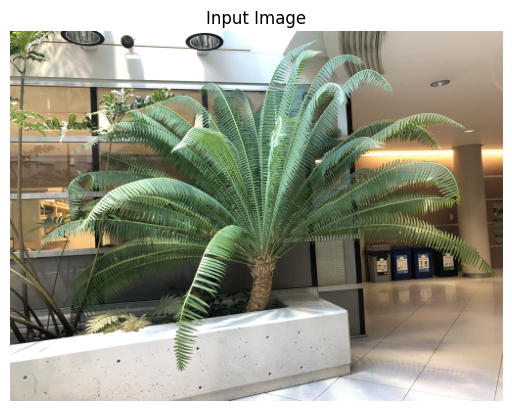

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main


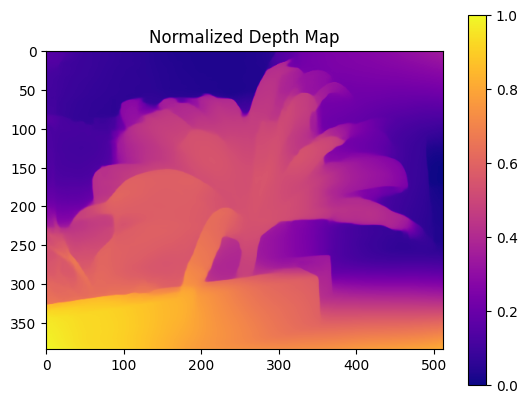

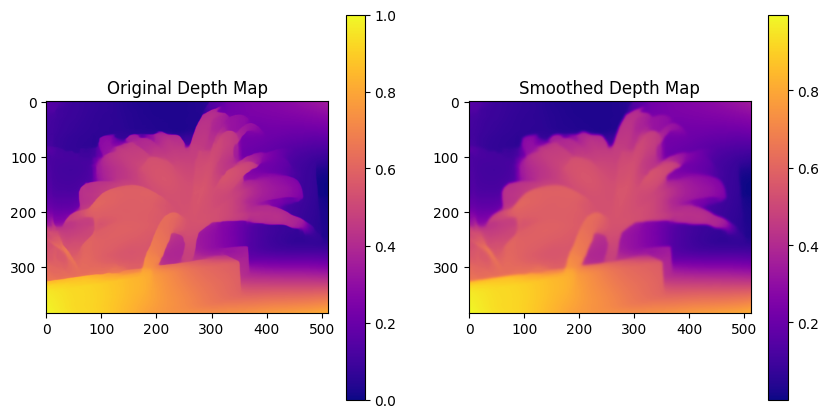

RayBundle origins shape: torch.Size([4096, 3])
RayBundle directions shape: torch.Size([4096, 3])
Density field shape: (16, 16, 16)
Mesh saved to output_mesh_new.obj
Mesh saved to output_mesh_new.obj


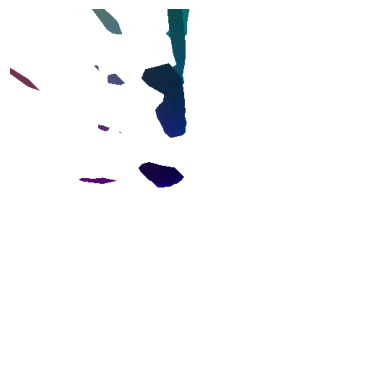

Rendered image saved as 'rendered_mesh.png'
Rotation animation saved as 'mesh_rotation.gif'


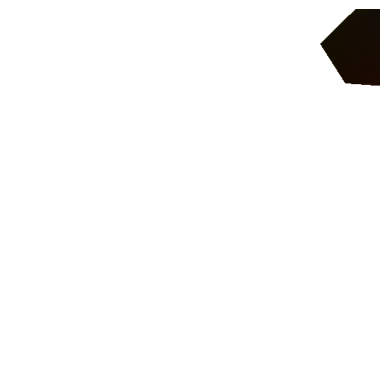

In [165]:
process_image_to_mesh("/content/image019.png", neural_radiance_field, "output_mesh_new.obj")
